In [2]:
import torch
import torchvision.models as models
import cv2
import numpy as np
import os
import glob
from keras.preprocessing import image
import skimage.feature as sf

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.convolutional import Convolution3D, MaxPooling3D
import keras.optimizers as opt
from keras.utils import np_utils, generic_utils
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection  import train_test_split

import keras.backend as K
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import SGD

from sklearn import preprocessing
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

In [3]:
def getImageList(imageDirectory):
  rImages = glob.glob(imageDirectory + "/*.jpg")
  rImages +=  glob.glob(imageDirectory + "/*.jpeg")
  rImages +=  glob.glob(imageDirectory + "/*.png")
  return rImages

def load_data(num_frames, factor):
  
  parent_dir  = "/content/drive/Shareddrives/Projects/Fall 2020 Projects/DL/UCF_video"
  parent_dir = os.path.abspath(parent_dir)
  act_classes = ['Diving-Side', 'Golf-Swing', 'Kicking', 'Lifting', 'Riding-Horse', 
                 'Run-Side', 'SkateBoarding-Front', 'Swing', 'Walk-Front']

  frames_list = []
  labels = []
  Xtr = []
  frame_count = 0

  for act_class in act_classes:
    class_dir = os.path.join(parent_dir, act_class)
    
    for video in os.listdir(class_dir):

      video_dir=os.path.join(class_dir,video)
      print ("IN: ", os.path.join(act_class,video))
      all_frames = getImageList(video_dir)
      all_frames=sorted(all_frames)
      frames_list=[]
      k=0

      if act_class == 'Diving-Side' or act_class== 'Swing':
        nextframe=2*factor
      elif act_class == 'Lifting':
        nextframe=5*factor
      elif act_class =='Kicking':
        nextframe=1*factor
      else:
        nextframe=3*factor

      frame = cv2.imread(all_frames[k])
      frame_count = 1
      while frame_count<=num_frames:
        norm = cv2.normalize(frame, None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        resized = cv2.resize(norm, (64,64), interpolation = cv2.INTER_AREA)
        resized=np.array(resized)
        x=resized.reshape((1,3,64,64))
        frames_list.append(x)

        k+=nextframe
        frame_count += 1
        if frame_count <= num_frames:
          frame = cv2.imread(all_frames[k])      
        
      Xtr.append(frames_list)
      labels.append(act_class)
  return Xtr,labels

In [4]:
def feature_extractor():
  model = models.mobilenet_v2(pretrained=True)
  new_base =  (list(model.children())[:-1])[0]
  return new_base

def extract_features(Xtr,new_base):
  for i in Xtr:
    for j in i:
      x=torch.Tensor(j)
      output= new_base[:3](x)
      j=output
  return Xtr

In [20]:
def data_add(Xtr, labels):
  new_labels=[]
  Xtr_new=[]


  for i in range (0,len(Xtr)):
    vid1=[]
    vid2=[]
    for j in range (0,len(Xtr[i])):
      if j%2==0:
        vid1.append(Xtr[i][j])
      else:
        vid2.append(Xtr[i][j])
    Xtr_new.append(vid1)
    Xtr_new.append(vid2)
    new_labels.append(labels[i])
    new_labels.append(labels[i])

  return Xtr_new, new_labels
      

In [6]:
def preprocess(labels,Xtr, nb_classes):

  y=np.zeros(len(labels))
  act_classes = ['Diving-Side', 'Golf-Swing', 'Kicking', 'Lifting', 'Riding-Horse', 
                 'Run-Side', 'SkateBoarding-Front', 'Swing', 'Walk-Front']
  for i in range (0, len(y)):
    if labels[i] in act_classes:
      y[i]=act_classes.index(labels[i])
  
  # convert class vectors to binary class matrices
  Y_train = np_utils.to_categorical(y, nb_classes)
  
  Xtr_new=np.array(len(Xtr))

  #for i in range (0,len(Xtr)):
    #temp=[]
    #for j in Xtr[i]:
    #  temp=torch.stack(Xtr[i],dim=0)
    #  temp=temp.detach().numpy()
    #Xtr[i]=temp
  Xtr_new=np.array(Xtr)
  print("Current shape:", Xtr_new.shape)
  Xtr_new=Xtr_new.reshape(300,3,10,64,64)
  print("New shape:", Xtr_new.shape)
  return Xtr_new,Y_train

In [7]:
# Define model
def kerasmod3():

  model = Sequential()
  model.add(BatchNormalization())

  model.add(Convolution3D(8, 5, input_shape=(3,10,64,64), activation='relu', data_format = 'channels_first'))
  model.add(Convolution3D(16, 3, activation='relu'))
  model.add(Convolution3D(32, 3, activation='relu'))

  model.add(Dropout(0.1))
  model.add(MaxPooling3D(pool_size=2))
  

  model.add(Dropout(0.1))

  model.add(Flatten())
  
  model.add(Dropout(0.1))

  model.add(Dense(128, kernel_initializer='normal', activation='relu'))

  model.add(Dense(9, kernel_initializer='normal'))

  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['categorical_accuracy'])

  return model

In [8]:
def main():

  act_classes = ['Diving-Side', 'Golf-Swing', 'Kicking', 'Lifting', 'Riding-Horse', 
                 'Run-Side', 'SkateBoarding-Front', 'Swing', 'Walk-Front']
  num_frames=20
  factor=1
  nb_classes =9
  #loading and preprocessing
  X,labels=load_data(num_frames,factor)

  new_base=feature_extractor()
  Xtr=extract_features(X,new_base)
  Xtr,labels=data_add(Xtr,labels)
  Xtr_new, Y_train=preprocess(labels,Xtr,nb_classes)  
  
  # CNN Training parameters

  X_train_new, X_val_new, y_train_new,y_val_new =  train_test_split(Xtr_new,Y_train, 
                                                                    test_size=0.25, random_state=24)

  # Train the model
  model=kerasmod3()
  hist = model.fit(X_train_new, y_train_new, batch_size=  32, epochs = 20,shuffle=True)
  #hist = model.fit(X_train_new, y_train_new, batch_size=32,epochs=20,validation_split=0.2, shuffle=True)


  # Evaluate the model
  score = model.evaluate(X_val_new, y_val_new, batch_size=32)
  print('Test score:', score[0])
  print('Test accuracy:', score[1]) 
  model.save("ucfmodel.h5")
  y_val_new1 = [np.argmax(y, axis=None, out=None) for y in y_val_new]
  y_pred=model.predict_classes(X_val_new)
  
  con_mat = tf.math.confusion_matrix(labels=y_val_new1, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,  index = act_classes,  columns = act_classes)
  print(con_mat_df)
  print(classification_report(y_val_new1,y_pred))
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

IN:  Diving-Side/001
IN:  Diving-Side/002
IN:  Diving-Side/003
IN:  Diving-Side/004
IN:  Diving-Side/005
IN:  Diving-Side/006
IN:  Diving-Side/007
IN:  Diving-Side/008
IN:  Diving-Side/009
IN:  Diving-Side/010
IN:  Diving-Side/011
IN:  Diving-Side/012
IN:  Diving-Side/013
IN:  Diving-Side/014
IN:  Golf-Swing/003
IN:  Golf-Swing/002
IN:  Golf-Swing/001
IN:  Golf-Swing/004
IN:  Golf-Swing/005
IN:  Golf-Swing/010
IN:  Golf-Swing/009
IN:  Golf-Swing/006
IN:  Golf-Swing/007
IN:  Golf-Swing/008
IN:  Golf-Swing/011
IN:  Golf-Swing/012
IN:  Golf-Swing/013
IN:  Golf-Swing/014
IN:  Golf-Swing/015
IN:  Golf-Swing/017
IN:  Golf-Swing/016
IN:  Golf-Swing/018
IN:  Kicking/009
IN:  Kicking/003
IN:  Kicking/005
IN:  Kicking/010
IN:  Kicking/001
IN:  Kicking/007
IN:  Kicking/006
IN:  Kicking/008
IN:  Kicking/004
IN:  Kicking/002
IN:  Kicking/011
IN:  Kicking/014
IN:  Kicking/015
IN:  Kicking/012
IN:  Kicking/016
IN:  Kicking/019
IN:  Kicking/018
IN:  Kicking/013
IN:  Kicking/020
IN:  Kicking/017
IN:  L

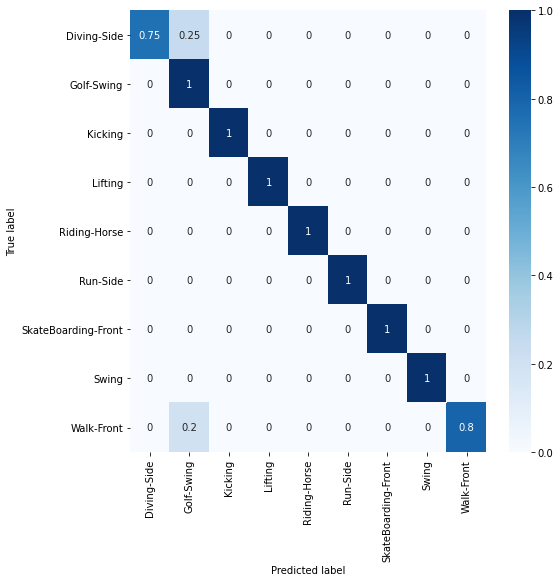

In [21]:
if __name__ == "__main__":
    main()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive
